In [8]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs
import bemcs.kernels_stress_displacement as kernels

np.random.seed(43)

## Implementing continuity and smoothness of slip

- For non-planar faults, implementing continuity & differentiability of slip implies we need to deal with a slip vector instead of a scalar, as we have done so far.
- For continuity of slip, we can enforce that the slip vector from patch 1 is equal to the slip vector from patch 2 for a given node $k$  

$\begin{equation} \begin{bmatrix} s_{1_x} \\ s_{1_y} \end{bmatrix}_k= \begin{bmatrix} s_{2_x} \\ s_{2_y} \end{bmatrix}_k \end{equation}$ 

- For smoothness of slip, we state that only the gradient of the slip vector taken along the fault direction ($\zeta$ is a scalar in the dip direction) is relevant i.e., $\frac{\partial s_x}{\partial\zeta},\frac{\partial s_y}{\partial\zeta}$ 

$\begin{equation} \begin{bmatrix} \frac{\partial s_x}{\partial\zeta_1} \\ \frac{\partial s_y}{\partial\zeta_1} \end{bmatrix}_k= \begin{bmatrix} \frac{\partial s_x}{\partial\zeta_2} \\ \frac{\partial s_y}{\partial\zeta_2} \end{bmatrix}_k \end{equation}$

### Planar fault elements

For the simplest case of co-planar elements/patches aligned with $\hat{x},\hat{y}$ axes, the slip components in the local coordinate system are identical to the global coordinates $\begin{bmatrix} s_x \\ s_y \end{bmatrix} = \begin{bmatrix} s_s \\ s_n \end{bmatrix}$. Slip continuity and smoothness over the node $k$ results in 2 sets of coupled equations, where the coupling is between each slip component and its gradient, but not across slip components. 

$\begin{align} \begin{bmatrix} s_{1_s} = s_{2_s} \\ 
\frac{\partial s_s}{\partial\zeta_1} =  \frac{\partial s_s}{\partial\zeta_2}\end{bmatrix}_k \\
\begin{bmatrix} s_{1_n} = s_{2_n} \\ 
\frac{\partial s_n}{\partial\zeta_1} = \frac{\partial s_n}{\partial\zeta_2} \end{bmatrix}_k \end{align}$ 

This is what is implemented in [the previous notebook on non-uniform sized planar patches](Nonuniform_planarpatches.ipynb) for $s_s$ alone while setting $s_n = 0$ for all patches.

### Non-planar fault elements

For non-planar elements/patches, $\begin{bmatrix} s_x \\ s_y \end{bmatrix} = \begin{bmatrix} s_sd_x + s_nn_x \\ s_sd_y + s_nn_y \end{bmatrix}$ where $\hat{d} = (d_x,d_y)$ is the unit vector in the patch dip direction while $\hat{n} = (n_x,n_y)$ is the unit vector in the patch normal direction. For 2 non-planar patches with orientations $\hat{d}_1,\hat{n}_1 = (d_{1_x},d_{1_y}),(n_{1_x},n_{1_y})$ and $\hat{d}_2,\hat{n}_2 = (d_{2_x},d_{2_y}),(n_{2_x},n_{2_y})$, we get 

$\begin{equation} \begin{bmatrix} s_{1_s}d_{1_x} + s_{1_n}n_{1_x} \\ s_{1_s}d_{1_y} + s_{1_n}n_{1_y} \end{bmatrix} = \begin{bmatrix} s_{2_s}d_{2_x} + s_{2_n}n_{2_x} \\ s_{2_s}d_{2_y} + s_{2_n}n_{2_y} \end{bmatrix} \end{equation}$

In terms of quadratic coefficients, the equation relating the three coefficients per fault element in shear and tensile directions $\left(q_s^{a,b,c},q_n^{a,b,c}\right)$, where $(a,b,c)$ are the 3 quadratic basis functions, and slip vector $\left(s_x,s_y\right)$ at a given point is 

$\begin{equation}\begin{bmatrix} s_x \\ s_y \end{bmatrix} = \begin{bmatrix} d_x & n_x \\ d_y & n_y \end{bmatrix} \begin{bmatrix} f_1 & f_2 & f_3 & 0 & 0 & 0\\ 0 & 0 & 0 & f_1 & f_2 & f_3\end{bmatrix} \begin{bmatrix} q_s^a \\ q_s^b \\ q_s^c \\ q_n^a \\ q_n^b \\ q_n^c\end{bmatrix}\end{equation}$

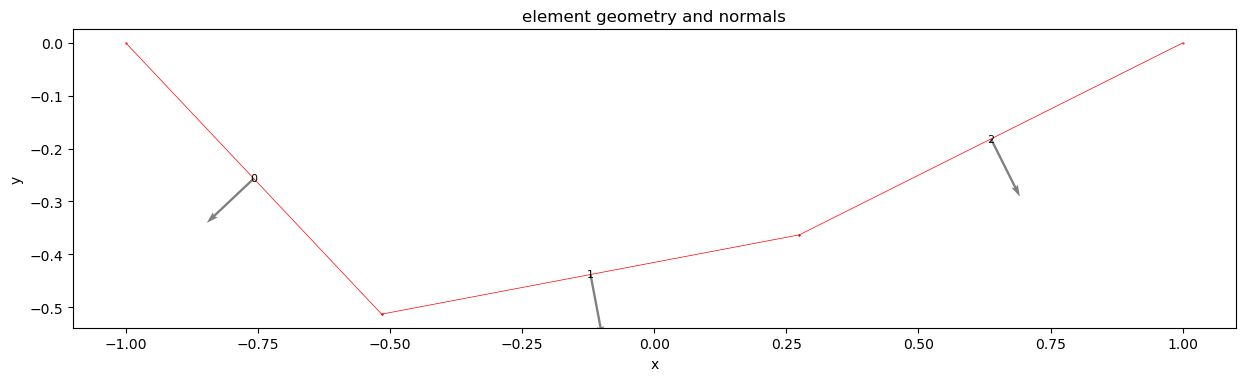

In [9]:
# use a non-uniform mesh
n_elements = 3
sorted_xlocs = np.sort(np.random.uniform(size=n_elements-1,low=-0.7,high=0.9))
sorted_ylocs = np.sort(np.random.uniform(size=n_elements-1,low=-0.7,high=0.7))

x1 = np.concatenate((np.array([-1.]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs,np.array([1.])))
y1 = np.concatenate((np.array([0.]), sorted_ylocs))
y2 = np.concatenate((sorted_ylocs,np.array([0.])))

# imposed slip at patch centers (make sure it is the same dimensions as x1)
slip_vector = np.random.uniform(size=n_elements)
# slip_vector = np.array((0,0.2,0.5,0.3,0.1))
# slip_vector = np.array((0.1,1.0,2.1,2.1,0.9,0.01))

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# plot geometry of mesh
plt.figure(figsize=(15,5))
bemcs.plot_element_geometry(elements)

## Design matrix and boundary conditions for the system

- We seek a solution to a system of equations $L.q = b$, where $L$ is the design matrix, $q$ is a vector of quadratic nodal coefficients and $b$ is a vector of boundary conditions. 
- The system is constructed for $N_p$ straight line elements that are used to discretize an arbitrary line.

### Unknowns
- $3\times N_p$ unknown $q_s$ coefficients + $3\times N_p$ unknown $q_n$ coefficients = $6\times N_p$ unknowns
### Equations and constraints
- $N_p$ slip values at element centers for $s_s$ (shear slip)
- $N_p$ slip values at element centers for $s_n$ (tensile slip)
- $2\times(N_p-1)$ equations for continuity of the slip vector at internal nodes (common to 2 elements)
- $2\times(N_p-1)$ equations for smoothness/differentiability of the slip vector at internal nodes (common to 2 elements)
- $2 \times 2$ equations for either the slip vector or gradient of the slip vector at the boundary nodes



In [10]:
# design matrices for slip and slip gradients at each 3qn
matrix_slip, matrix_slipgradient = kernels.get_designmatrix_3qn(elements)
matrix_system = np.zeros((len(elements)*3,len(elements)*3))

""" boundary conditions to solve for 3xNpatch unknown 3qn coefficients are as follows:
    (1) Npatch slip values at patch centers
    (2) Npatch-1 internal slip continuity at overlapping nodes
    (3) Npatch-1 internal slip gradient continuity at overlapping nodes
    (4) 2 slip gradients at the boundaries
"""

# Boundary conditions are ordered as patch1[n1,n2],patch1[n3]=patch2[n1],patch1[n3]grad=patch1[n1]grad,patch2[n2],....,patchN[n2,n3]
BCvector = np.zeros((len(elements)*3,1))
# slip gradients at the boundaries (we set them to 0 in this example)
BCvector[0] = 0
BCvector[-1] = 0

# slip imposed at central nodes of each patch
BCvector[1:-1:3] = slip_vector.reshape(-1,1)

# Linear operator for BCs as a matrix
# boundary nodes
matrix_system[0,:] = matrix_slipgradient[0,:]
matrix_system[-1,:] = matrix_slipgradient[-1,:]
# patch center nodes
matrix_system[1:-1:3,:] = matrix_slip[1:-1:3,:]
# overlapping interior nodes (apply slip continuity and smoothness)
matrix_system[2:-3:3,:] = matrix_slip[2:-3:3,:] - matrix_slip[3:-2:3,:]
matrix_system[3:-2:3,:] = matrix_slipgradient[2:-3:3,:] - matrix_slipgradient[3:-2:3,:]

# compute quadratic node coefficients
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print(quadratic_coefs.reshape(n_elements,3))


[[0.24668551 0.32713906 0.48804615]
 [0.719355   0.85913749 0.86346937]
 [0.75423902 0.66609021 0.62201581]]


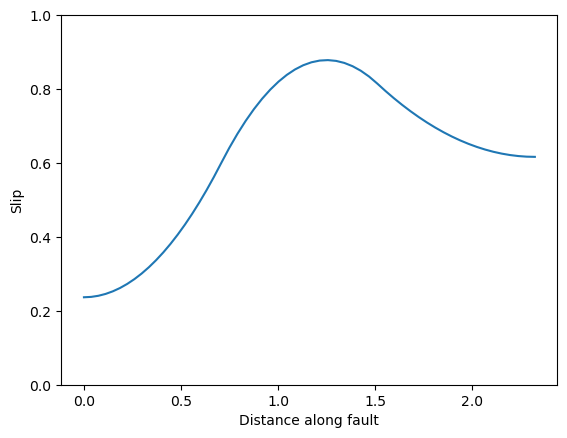

In [11]:
# compute slip over each patch (evaluate distance along a patch with n_pts nodes)
n_pts = 20
xnodes = np.zeros((n_elements*n_pts,1))

# get slip along the fault from quadratic coefficients
slip_fullfault = np.zeros((n_elements*n_pts,1))
for i in range(len(elements)):
    coef_index = list(range(3*i, 3*i+3, 1))
    node_index = list(range(n_pts*i, n_pts*(i+1), 1))
    # print(node_index)
    # print(xnodes[node_index[0]])

    x_vec = np.linspace(-elements[i]["half_length"],elements[i]["half_length"],n_pts)
    L = 0
    for count in range(i+1):
        L += elements[count]["length"]
        # print(count)
    # print(f"L={L}")
    # print(f"Patch length = {elements[i]['length']}")

    xnodes[node_index,0] = x_vec - elements[i]["half_length"] + L

    slip_patch,_ = bemcs.get_slip_slipgradient(x_vec, elements[i]["half_length"], quadratic_coefs[coef_index])
    slip_fullfault[node_index] = slip_patch

plt.figure()
# plt.stem(0.5*(x1+x2),slip_vector,'ko-')
plt.plot(xnodes,slip_fullfault,'-')
plt.ylabel('Slip')
plt.xlabel('Distance along fault')
plt.ylim(0,1)
plt.show()



In [12]:
# compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_t = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

In [13]:
# evl = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu)


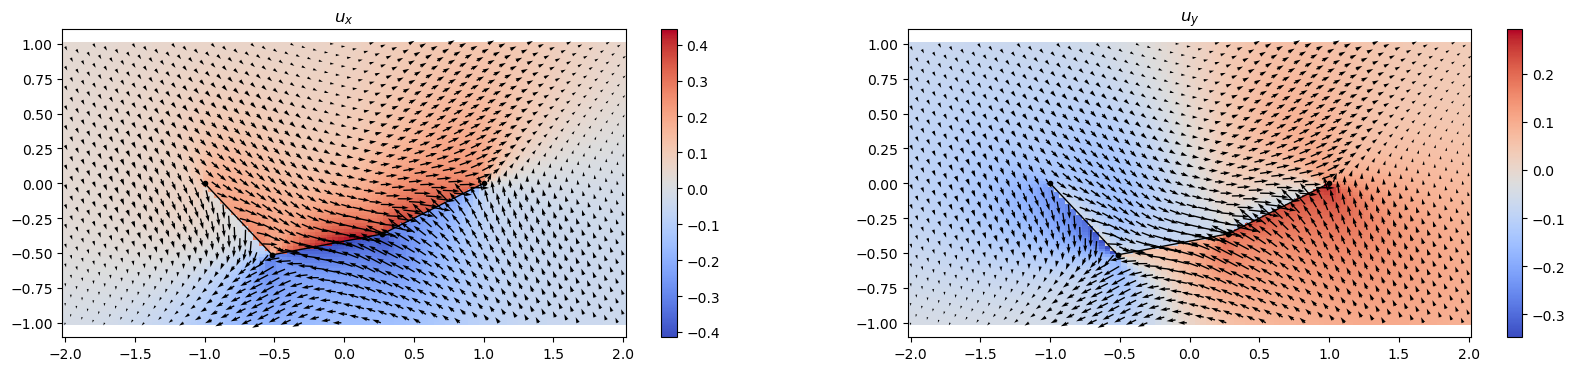

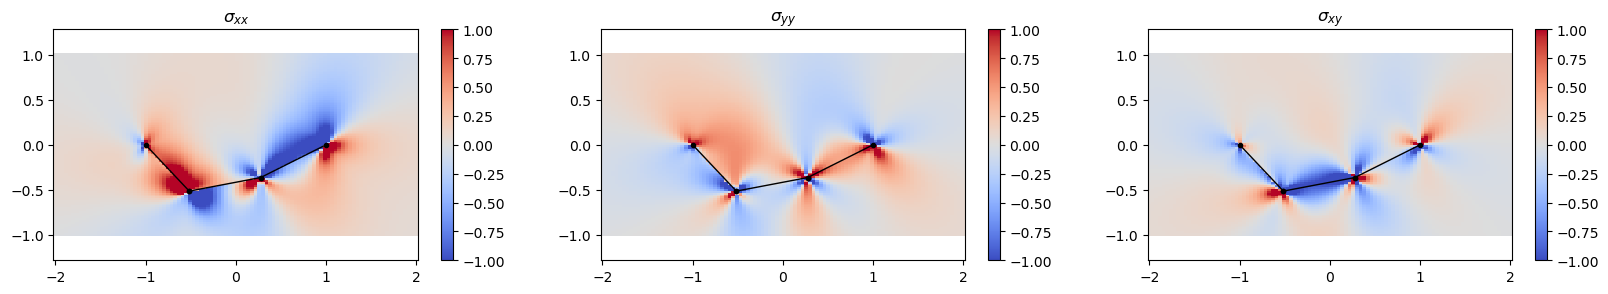

In [14]:
# plot displacements and stresses

nskip_plot = 7 # plotting for vectors

# displacements
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
toplot = kernels_s[3] @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
# plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],kernels_s[3][0::nskip_plot]@quadratic_coefs,kernels_s[4][0::nskip_plot]@quadratic_coefs)
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
toplot = kernels_s[4] @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],kernels_s[3][0::nskip_plot]@quadratic_coefs,kernels_s[4][0::nskip_plot]@quadratic_coefs)
# plt.clim(-0.2,0.2)
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
toplot = kernels_s[0] @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = kernels_s[1] @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = kernels_s[2] @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()